# Corporación Favorita Grocery Sales Forecasting
## w02_d02_FE_rolling.ipynb

**Author:** Alberto Diaz Durana  
**Date:** November 2025  
**Purpose:** Create rolling statistics (7/14/30-day moving averages and standard deviations)

---

## Objectives

This notebook accomplishes the following:

- Load Day 1 output (guayas_with_lags.pkl, 32 columns)
- Sort by (store_nbr, item_nbr, date) to maintain temporal order
- Create 7/14/30-day rolling averages (trend smoothing)
- Create 7/14/30-day rolling standard deviations (volatility capture)
- Use min_periods=1 to reduce NaN (<1% expected)
- Validate smoothing effect with visualizations
- Export intermediate dataset (38 columns)

---

## Business Context

**Why rolling statistics matter:**

Rolling features smooth noise and reveal underlying patterns:
- Short window (7-day): Captures recent momentum and weekly trends
- Medium window (14-day): Balances responsiveness with stability
- Long window (30-day): Provides baseline/seasonal reference
- Volatility (std): Identifies stable vs erratic demand patterns

**Applications for forecasting:**
- Smoothed averages reduce overfitting to daily noise
- Multiple windows capture different time horizons
- Volatility metrics enable uncertainty quantification
- Together with lags, provide rich temporal context for Week 3 models

**Deliverables:**
- 6 rolling features (3 averages + 3 standard deviations)
- Smoothing visualizations (raw vs smoothed for 5 items)
- Volatility analysis (top 10 volatile items)
- Intermediate dataset: guayas_with_rolling.pkl

---

## Input Dependencies

From Week 2 Day 1:
- Dataset: guayas_with_lags.pkl (300,896 rows × 32 columns)
- Contains: 28 base features + 4 lag features
- Quality: Temporal order verified, lag calculations validated
- Date range: 2013-01-02 to 2017-08-15

---

## 1. Load Data & Setup

**Objective:** Load Day 1 dataset and prepare for rolling window calculations

**Activities:**
- Import libraries and define project paths
- Load guayas_with_lags.pkl from Day 1
- Verify shape (300,896 rows × 32 columns expected)
- Confirm temporal sort maintained from Day 1
- Display sample data

**Expected output:** 
- Dataset loaded successfully
- Shape verification (32 columns)
- Memory usage reported
- Ready for rolling feature creation

In [1]:
# Cell 1: Imports and Project Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Determine paths (works from notebooks/ or project root)
current_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
PROJECT_ROOT = current_dir.parent if current_dir.name == 'notebooks' else current_dir

DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DATA_RESULTS = PROJECT_ROOT / 'data' / 'results' / 'features'
OUTPUTS_FIGURES = PROJECT_ROOT / 'outputs' / 'figures' / 'features'

# Create output directories if they don't exist
DATA_RESULTS.mkdir(parents=True, exist_ok=True)
OUTPUTS_FIGURES.mkdir(parents=True, exist_ok=True)

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("WEEK 2 DAY 2: ROLLING STATISTICS FEATURE ENGINEERING")
print("=" * 80)
print(f"\nProject root: {PROJECT_ROOT.resolve()}")
print(f"Data processed: {DATA_PROCESSED.resolve()}")
print(f"Results output: {DATA_RESULTS.resolve()}")
print(f"Figures output: {OUTPUTS_FIGURES.resolve()}")
print(f"\nLibraries loaded successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

WEEK 2 DAY 2: ROLLING STATISTICS FEATURE ENGINEERING

Project root: C:\Users\adiaz\OneDrive\Dokumente\PythonScripts\MasterClass\Demand-forecasting-in-retail
Data processed: C:\Users\adiaz\OneDrive\Dokumente\PythonScripts\MasterClass\Demand-forecasting-in-retail\data\processed
Results output: C:\Users\adiaz\OneDrive\Dokumente\PythonScripts\MasterClass\Demand-forecasting-in-retail\data\results\features
Figures output: C:\Users\adiaz\OneDrive\Dokumente\PythonScripts\MasterClass\Demand-forecasting-in-retail\outputs\figures\features

Libraries loaded successfully!
Pandas version: 2.1.4
NumPy version: 1.26.4


In [2]:
# Cell 2: Load Day 1 Dataset (with lag features)

print("Loading Day 1 dataset with lag features...")
print("-" * 80)

# Load pickled dataset from Day 1
df = pd.read_pickle(DATA_PROCESSED / 'guayas_with_lags.pkl')

print(f"OK: Dataset loaded successfully!")
print(f"\nShape: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")

print(f"\nDate range:")
print(f"  Start: {df['date'].min().date()}")
print(f"  End: {df['date'].max().date()}")
print(f"  Days: {(df['date'].max() - df['date'].min()).days}")

print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Verify lag features present
lag_cols = [col for col in df.columns if 'lag' in col.lower()]
print(f"\nLag features from Day 1 ({len(lag_cols)}):")
for col in lag_cols:
    print(f"  - {col}")

print(f"\nTemporal order check (first 5 rows):")
print(df[['store_nbr', 'item_nbr', 'date', 'unit_sales']].head(5))

print("\n" + "=" * 80)
print("Dataset ready for rolling statistics creation!")

Loading Day 1 dataset with lag features...
--------------------------------------------------------------------------------
OK: Dataset loaded successfully!

Shape: (300896, 32)
  Rows: 300,896
  Columns: 32

Date range:
  Start: 2013-01-02
  End: 2017-08-15
  Days: 1686

Memory usage: 162.5 MB

Lag features from Day 1 (4):
  - unit_sales_lag1
  - unit_sales_lag7
  - unit_sales_lag14
  - unit_sales_lag30

Temporal order check (first 5 rows):
   store_nbr  item_nbr       date  unit_sales
0         24     96995 2013-06-08         2.0
1         24     96995 2013-08-24         1.0
2         24     96995 2013-09-08         1.0
3         24     96995 2013-11-01         1.0
4         24     96995 2013-11-29         1.0

Dataset ready for rolling statistics creation!


## 2. Create Rolling Average Features

**Objective:** Generate 7, 14, 30-day rolling mean features for trend smoothing

**Activities:**
- Create unit_sales_7d_avg (7-day moving average)
- Create unit_sales_14d_avg (14-day moving average)
- Create unit_sales_30d_avg (30-day moving average)
- Use groupby(['store_nbr', 'item_nbr']).rolling(window=k, min_periods=1)
- Set min_periods=1 to compute with partial windows (reduces NaN)

**Expected output:** 
- 3 new rolling average columns
- NaN counts <1% (min_periods=1 effect)
- Computation time ~3-5 minutes

WARNING: min_periods=1 means first few observations use partial windows (e.g., day 3 uses only 3 days for 7-day avg). This is acceptable for reducing NaN but creates lower-quality values at start of each store-item series.

In [3]:
# Cell 3: Create Rolling Average Features (7, 14, 30-day windows)

print("Creating rolling average features...")
print("-" * 80)

start_time = time.time()

# Create 7-day rolling average
print("Creating unit_sales_7d_avg (7-day moving average)...")
df['unit_sales_7d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# Create 14-day rolling average
print("Creating unit_sales_14d_avg (14-day moving average)...")
df['unit_sales_14d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=14, min_periods=1).mean()
)

# Create 30-day rolling average
print("Creating unit_sales_30d_avg (30-day moving average)...")
df['unit_sales_30d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean()
)

elapsed = time.time() - start_time

print(f"\nOK: All rolling average features created in {elapsed:.1f} seconds")
print("=" * 80)

# New shape
print(f"\nNew shape: {df.shape}")
print(f"  Columns added: 3")
print(f"  Total columns: {df.shape[1]}")

# Check NaN counts
print(f"\nNaN counts per rolling average feature:")
print(f"  unit_sales_7d_avg:  {df['unit_sales_7d_avg'].isnull().sum():>6,} ({df['unit_sales_7d_avg'].isnull().sum()/len(df)*100:.2f}%)")
print(f"  unit_sales_14d_avg: {df['unit_sales_14d_avg'].isnull().sum():>6,} ({df['unit_sales_14d_avg'].isnull().sum()/len(df)*100:.2f}%)")
print(f"  unit_sales_30d_avg: {df['unit_sales_30d_avg'].isnull().sum():>6,} ({df['unit_sales_30d_avg'].isnull().sum()/len(df)*100:.2f}%)")

# Verify rolling features on sample
print(f"\nSample verification - Store 24, Item 96995 (first 10 rows):")
sample = df[(df['store_nbr'] == 24) & (df['item_nbr'] == 96995)].head(10)
print(sample[['date', 'unit_sales', 'unit_sales_7d_avg', 'unit_sales_14d_avg', 'unit_sales_30d_avg']].to_string(index=False))

print("\n" + "=" * 80)
print("Rolling average features complete!")

Creating rolling average features...
--------------------------------------------------------------------------------
Creating unit_sales_7d_avg (7-day moving average)...
Creating unit_sales_14d_avg (14-day moving average)...
Creating unit_sales_30d_avg (30-day moving average)...

OK: All rolling average features created in 15.2 seconds

New shape: (300896, 35)
  Columns added: 3
  Total columns: 35

NaN counts per rolling average feature:
  unit_sales_7d_avg:       0 (0.00%)
  unit_sales_14d_avg:      0 (0.00%)
  unit_sales_30d_avg:      0 (0.00%)

Sample verification - Store 24, Item 96995 (first 10 rows):
      date  unit_sales  unit_sales_7d_avg  unit_sales_14d_avg  unit_sales_30d_avg
2013-06-08         2.0           2.000000            2.000000            2.000000
2013-08-24         1.0           1.500000            1.500000            1.500000
2013-09-08         1.0           1.333333            1.333333            1.333333
2013-11-01         1.0           1.250000            1.2

## 3. Create Rolling Standard Deviation Features

**Objective:** Capture recent volatility and demand stability patterns

**Activities:**
- Create unit_sales_7d_std (7-day rolling standard deviation)
- Create unit_sales_14d_std (14-day rolling standard deviation)
- Create unit_sales_30d_std (30-day rolling standard deviation)
- Use same groupby + rolling pattern with .std()
- Use min_periods=2 (std requires at least 2 values)

**Expected output:** 
- 3 new rolling std columns
- NaN counts <5% (min_periods=2 creates NaN for single observations)
- High volatility items identifiable for analysis

WARNING: Standard deviation requires at least 2 values. First observation per store-item will be NaN.

In [4]:
# Cell 4: Create Rolling Standard Deviation Features (7, 14, 30-day windows)

print("Creating rolling standard deviation features...")
print("-" * 80)

start_time = time.time()

# Create 7-day rolling std
print("Creating unit_sales_7d_std (7-day volatility)...")
df['unit_sales_7d_std'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=7, min_periods=2).std()
)

# Create 14-day rolling std
print("Creating unit_sales_14d_std (14-day volatility)...")
df['unit_sales_14d_std'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=14, min_periods=2).std()
)

# Create 30-day rolling std
print("Creating unit_sales_30d_std (30-day volatility)...")
df['unit_sales_30d_std'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=30, min_periods=2).std()
)

elapsed = time.time() - start_time

print(f"\nOK: All rolling std features created in {elapsed:.1f} seconds")
print("=" * 80)

# New shape
print(f"\nNew shape: {df.shape}")
print(f"  Columns added: 3")
print(f"  Total columns: {df.shape[1]}")

# Check NaN counts
print(f"\nNaN counts per rolling std feature:")
print(f"  unit_sales_7d_std:  {df['unit_sales_7d_std'].isnull().sum():>6,} ({df['unit_sales_7d_std'].isnull().sum()/len(df)*100:.2f}%)")
print(f"  unit_sales_14d_std: {df['unit_sales_14d_std'].isnull().sum():>6,} ({df['unit_sales_14d_std'].isnull().sum()/len(df)*100:.2f}%)")
print(f"  unit_sales_30d_std: {df['unit_sales_30d_std'].isnull().sum():>6,} ({df['unit_sales_30d_std'].isnull().sum()/len(df)*100:.2f}%)")

# Verify rolling std on sample
print(f"\nSample verification - Store 24, Item 96995 (first 10 rows):")
sample = df[(df['store_nbr'] == 24) & (df['item_nbr'] == 96995)].head(10)
print(sample[['date', 'unit_sales', 'unit_sales_7d_std', 'unit_sales_14d_std', 'unit_sales_30d_std']].to_string(index=False))

# Volatility statistics
print(f"\n" + "-" * 80)
print("Volatility statistics (7-day std):")
print(f"  Mean: {df['unit_sales_7d_std'].mean():.2f}")
print(f"  Median: {df['unit_sales_7d_std'].median():.2f}")
print(f"  Max: {df['unit_sales_7d_std'].max():.2f}")

print("\n" + "=" * 80)
print("Rolling standard deviation features complete!")

Creating rolling standard deviation features...
--------------------------------------------------------------------------------
Creating unit_sales_7d_std (7-day volatility)...
Creating unit_sales_14d_std (14-day volatility)...
Creating unit_sales_30d_std (30-day volatility)...

OK: All rolling std features created in 14.7 seconds

New shape: (300896, 38)
  Columns added: 3
  Total columns: 38

NaN counts per rolling std feature:
  unit_sales_7d_std:  19,692 (6.54%)
  unit_sales_14d_std: 19,692 (6.54%)
  unit_sales_30d_std: 19,692 (6.54%)

Sample verification - Store 24, Item 96995 (first 10 rows):
      date  unit_sales  unit_sales_7d_std  unit_sales_14d_std  unit_sales_30d_std
2013-06-08         2.0                NaN                 NaN                 NaN
2013-08-24         1.0           0.707107            0.707107            0.707107
2013-09-08         1.0           0.577350            0.577350            0.577350
2013-11-01         1.0           0.500000            0.500000    

## 4. Validation & Visualization

**Objective:** Verify smoothing effectiveness and identify high-volatility items

**Activities:**
- Plot raw sales vs smoothed (7/14/30-day avg) for 5 sample items
- Visualize smoothing effect: noise reduction without excessive lag
- Identify top 10 volatile items (highest 7-day std)
- Create volatility distribution histogram

**Expected output:** 
- 5 smoothing visualizations (raw + 3 rolling averages)
- Volatility analysis table (top 10 items)
- Histogram showing volatility distribution
- Validation report (smoothing reduces noise as expected)

Creating smoothing validation visualizations...
--------------------------------------------------------------------------------
OK: Smoothing visualization saved to c:\Users\adiaz\OneDrive\Dokumente\PythonScripts\MasterClass\Demand-forecasting-in-retail\outputs\figures\features\rolling_smoothing_validation.png


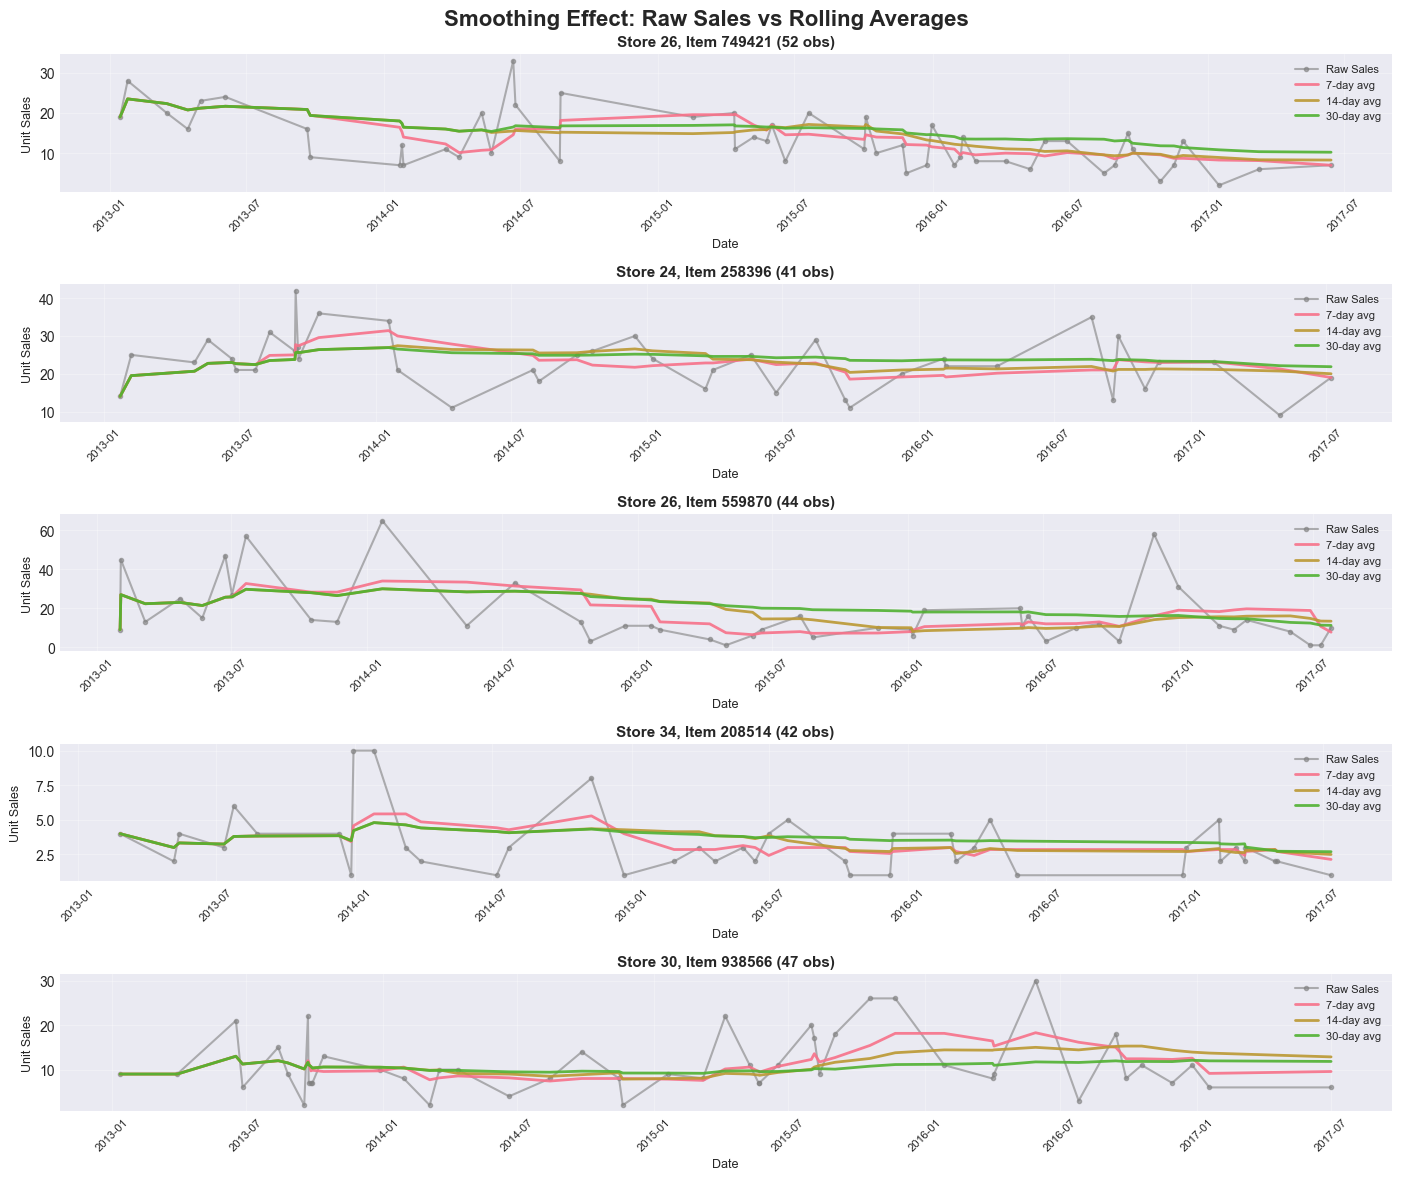


Observation: Longer windows provide smoother trends, shorter windows more responsive


In [5]:
# Cell 5: Smoothing Effect Visualization (Raw vs Smoothed)

print("Creating smoothing validation visualizations...")
print("-" * 80)

# Select 5 items with good data availability for visualization
top_items = df.groupby('item_nbr').size().sort_values(ascending=False).head(15).index
viz_items = [top_items[i] for i in [0, 3, 6, 9, 12]]  # Spread across frequency spectrum

fig, axes = plt.subplots(5, 1, figsize=(14, 12))
fig.suptitle('Smoothing Effect: Raw Sales vs Rolling Averages', 
             fontsize=16, fontweight='bold')

for idx, item in enumerate(viz_items):
    ax = axes[idx]
    
    # Get sample data for this item (first store that has it)
    item_data = df[df['item_nbr'] == item]
    sample_store = item_data['store_nbr'].value_counts().index[0]
    
    # Filter to one store-item pair, limit to 150 observations for clarity
    plot_data = item_data[item_data['store_nbr'] == sample_store].head(150)
    
    # Plot raw sales and rolling averages
    ax.plot(plot_data['date'], plot_data['unit_sales'], 
            label='Raw Sales', linewidth=1.5, marker='o', markersize=3, 
            alpha=0.6, color='gray')
    ax.plot(plot_data['date'], plot_data['unit_sales_7d_avg'], 
            label='7-day avg', linewidth=2, linestyle='-', alpha=0.9)
    ax.plot(plot_data['date'], plot_data['unit_sales_14d_avg'], 
            label='14-day avg', linewidth=2, linestyle='-', alpha=0.9)
    ax.plot(plot_data['date'], plot_data['unit_sales_30d_avg'], 
            label='30-day avg', linewidth=2, linestyle='-', alpha=0.9)
    
    # Formatting
    ax.set_title(f'Store {sample_store}, Item {item} ({len(plot_data)} obs)', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Date', fontsize=9)
    ax.set_ylabel('Unit Sales', fontsize=9)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()

# Save figure
save_path = OUTPUTS_FIGURES / 'rolling_smoothing_validation.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"OK: Smoothing visualization saved to {save_path}")

plt.show()

print("\n" + "=" * 80)
print("Observation: Longer windows provide smoother trends, shorter windows more responsive")

Analyzing high-volatility items...
--------------------------------------------------------------------------------
Top 10 Most Volatile Items (by average 7-day std):
          avg_7d_std  avg_sales  total_sales  num_obs     family
item_nbr                                                        
2060793        76.45      74.09        815.0       11  BEVERAGES
2061214        67.01      50.20        753.0       15  BEVERAGES
2084557        49.05      18.38        239.0       13   CLEANING
2015820        46.75      20.62        433.0       21  GROCERY I
913968         39.22      32.24       3643.0      113  GROCERY I
1962621        38.21      62.81       6407.0      102  BEVERAGES
819932         35.49      60.70      19061.0      314  BEVERAGES
257847         33.17      66.53      21424.0      322  BEVERAGES
2042941        30.92      57.77       3466.0       60  BEVERAGES
839362         30.25      43.42      14631.0      337  BEVERAGES

----------------------------------------------------

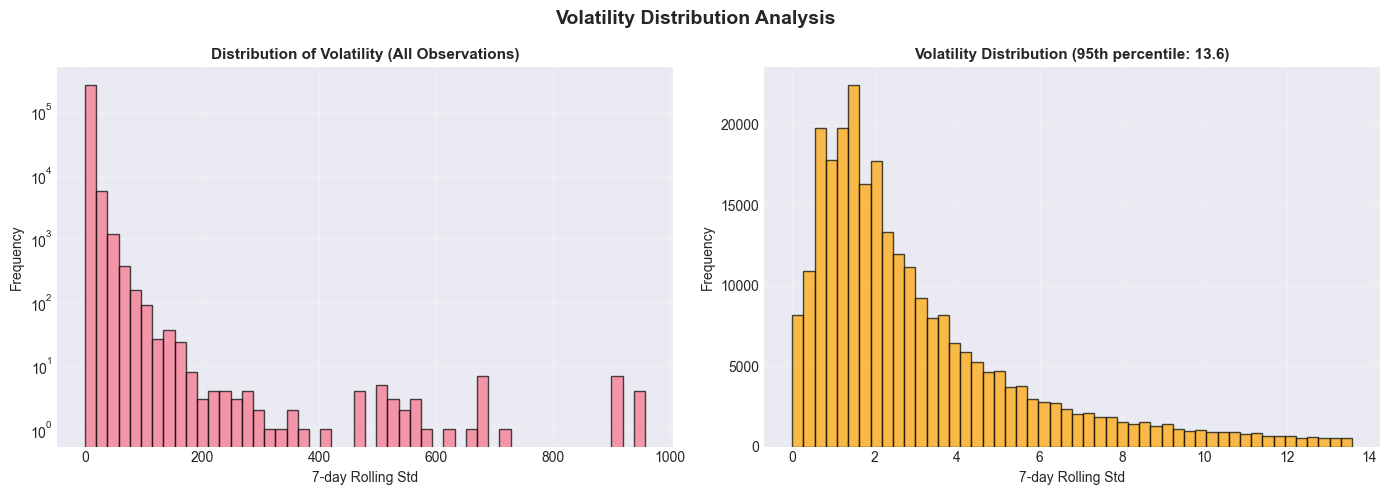


Volatility analysis complete!
  Most volatile item: std = 76.45
  Most stable item: std = nan
  95th percentile: std = 13.57


In [6]:
# Cell 6: Volatility Analysis - Identify High-Volatility Items

print("Analyzing high-volatility items...")
print("-" * 80)

# Calculate average volatility per item (across all stores)
item_volatility = df.groupby('item_nbr').agg({
    'unit_sales_7d_std': 'mean',
    'unit_sales': ['mean', 'sum', 'count'],
    'family': 'first'
}).round(2)

# Flatten column names
item_volatility.columns = ['avg_7d_std', 'avg_sales', 'total_sales', 'num_obs', 'family']

# Sort by volatility
item_volatility = item_volatility.sort_values('avg_7d_std', ascending=False)

print("Top 10 Most Volatile Items (by average 7-day std):")
print("=" * 80)
print(item_volatility.head(10).to_string())

print("\n" + "-" * 80)
print("Bottom 10 Most Stable Items (lowest volatility):")
print("-" * 80)
print(item_volatility.tail(10).to_string())

# Volatility by family
print("\n" + "=" * 80)
print("Average volatility by product family:")
print("-" * 80)
family_volatility = df.groupby('family')['unit_sales_7d_std'].mean().sort_values(ascending=False)
print(family_volatility.round(2))

# Create volatility distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Volatility Distribution Analysis', fontsize=14, fontweight='bold')

# Histogram 1: Overall distribution (log scale for wide range)
ax1 = axes[0]
df['unit_sales_7d_std'].dropna().hist(bins=50, ax=ax1, edgecolor='black', alpha=0.7)
ax1.set_xlabel('7-day Rolling Std', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.set_title('Distribution of Volatility (All Observations)', fontsize=11, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Histogram 2: Zoomed view (exclude extreme outliers)
ax2 = axes[1]
volatility_95th = df['unit_sales_7d_std'].quantile(0.95)
df[df['unit_sales_7d_std'] <= volatility_95th]['unit_sales_7d_std'].hist(
    bins=50, ax=ax2, edgecolor='black', alpha=0.7, color='orange')
ax2.set_xlabel('7-day Rolling Std', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title(f'Volatility Distribution (95th percentile: {volatility_95th:.1f})', 
              fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
save_path = OUTPUTS_FIGURES / 'volatility_distribution.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nOK: Volatility distribution saved to {save_path}")

plt.show()

print("\n" + "=" * 80)
print("Volatility analysis complete!")
print(f"  Most volatile item: std = {item_volatility['avg_7d_std'].iloc[0]:.2f}")
print(f"  Most stable item: std = {item_volatility['avg_7d_std'].iloc[-1]:.2f}")
print(f"  95th percentile: std = {volatility_95th:.2f}")

## 5. Save Checkpoint & Documentation

**Objective:** Export intermediate dataset and document rolling features

**Activities:**
- Save intermediate dataset: guayas_with_rolling.pkl (38 columns)
- Update feature dictionary with 6 new rolling features
- Generate summary statistics for all features
- Prepare for Day 3 (oil price integration)

**Expected output:** 
- guayas_with_rolling.pkl in data/processed/
- Feature dictionary entries (6 new)
- Summary report
- Ready for Week 2 Day 3

In [7]:
# Cell 7: Save Checkpoint Dataset

print("Saving intermediate dataset with rolling features...")
print("-" * 80)

# Save to pickle (compressed, preserves dtypes)
output_path = DATA_PROCESSED / 'guayas_with_rolling.pkl'
df.to_pickle(output_path)

print(f"OK: Dataset saved to {output_path}")
print(f"\nDataset specifications:")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")
print(f"  File size: {output_path.stat().st_size / 1024**2:.1f} MB")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\nNew columns added (6 rolling features):")
rolling_cols = [col for col in df.columns if 'avg' in col or 'std' in col]
for col in rolling_cols:
    print(f"  - {col}")

print(f"\nFeature progression:")
print(f"  Week 1 Day 5: 28 columns (base features)")
print(f"  Week 2 Day 1: 32 columns (+4 lag features)")
print(f"  Week 2 Day 2: 38 columns (+6 rolling features)")
print(f"  Cumulative: 10 engineered features added")

print(f"\nColumn list (38 total):")
print(df.columns.tolist())

print("\n" + "=" * 80)
print("Checkpoint saved successfully!")
print("Ready for Week 2 Day 3: Oil Price Features")

Saving intermediate dataset with rolling features...
--------------------------------------------------------------------------------
OK: Dataset saved to c:\Users\adiaz\OneDrive\Dokumente\PythonScripts\MasterClass\Demand-forecasting-in-retail\data\processed\guayas_with_rolling.pkl

Dataset specifications:
  Rows: 300,896
  Columns: 38
  File size: 66.8 MB
  Memory usage: 176.3 MB

New columns added (6 rolling features):
  - unit_sales_7d_avg
  - unit_sales_14d_avg
  - unit_sales_30d_avg
  - unit_sales_7d_std
  - unit_sales_14d_std
  - unit_sales_30d_std

Feature progression:
  Week 1 Day 5: 28 columns (base features)
  Week 2 Day 1: 32 columns (+4 lag features)
  Week 2 Day 2: 38 columns (+6 rolling features)
  Cumulative: 10 engineered features added

Column list (38 total):
['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'family', 'class', 'perishable', 'city', 'state', 'type', 'cluster', 'year', 'month', 'day', 'day_of_week', 'day_of_month', 'is_weekend', 'is_h

In [10]:
# Cell 8: Feature Dictionary Update

print("Documenting new rolling features...")
print("-" * 80)

# Feature dictionary entries
feature_dict = {
    'unit_sales_7d_avg': {
        'description': '7-day rolling average of unit_sales',
        'type': 'Rolling statistic (mean)',
        'source': 'unit_sales',
        'method': 'groupby([store_nbr, item_nbr]).rolling(7, min_periods=1).mean()',
        'window': '7 days',
        'nan_count': df['unit_sales_7d_avg'].isnull().sum(),
        'nan_pct': f"{df['unit_sales_7d_avg'].isnull().sum()/len(df)*100:.2f}%",
        'rationale': 'Captures recent weekly trend, smooths daily noise'
    },
    'unit_sales_14d_avg': {
        'description': '14-day rolling average of unit_sales',
        'type': 'Rolling statistic (mean)',
        'source': 'unit_sales',
        'method': 'groupby([store_nbr, item_nbr]).rolling(14, min_periods=1).mean()',
        'window': '14 days',
        'nan_count': df['unit_sales_14d_avg'].isnull().sum(),
        'nan_pct': f"{df['unit_sales_14d_avg'].isnull().sum()/len(df)*100:.2f}%",
        'rationale': 'Balances responsiveness with stability, bi-weekly baseline'
    },
    'unit_sales_30d_avg': {
        'description': '30-day rolling average of unit_sales',
        'type': 'Rolling statistic (mean)',
        'source': 'unit_sales',
        'method': 'groupby([store_nbr, item_nbr]).rolling(30, min_periods=1).mean()',
        'window': '30 days',
        'nan_count': df['unit_sales_30d_avg'].isnull().sum(),
        'nan_pct': f"{df['unit_sales_30d_avg'].isnull().sum()/len(df)*100:.2f}%",
        'rationale': 'Long-term monthly baseline, removes short-term fluctuations'
    },
    'unit_sales_7d_std': {
        'description': '7-day rolling standard deviation of unit_sales',
        'type': 'Rolling statistic (volatility)',
        'source': 'unit_sales',
        'method': 'groupby([store_nbr, item_nbr]).rolling(7, min_periods=2).std()',
        'window': '7 days',
        'nan_count': df['unit_sales_7d_std'].isnull().sum(),
        'nan_pct': f"{df['unit_sales_7d_std'].isnull().sum()/len(df)*100:.2f}%",
        'mean': f"{df['unit_sales_7d_std'].mean():.2f}",
        'median': f"{df['unit_sales_7d_std'].median():.2f}",
        'rationale': 'Captures recent demand volatility, identifies erratic items'
    },
    'unit_sales_14d_std': {
        'description': '14-day rolling standard deviation of unit_sales',
        'type': 'Rolling statistic (volatility)',
        'source': 'unit_sales',
        'method': 'groupby([store_nbr, item_nbr]).rolling(14, min_periods=2).std()',
        'window': '14 days',
        'nan_count': df['unit_sales_14d_std'].isnull().sum(),
        'nan_pct': f"{df['unit_sales_14d_std'].isnull().sum()/len(df)*100:.2f}%",
        'mean': f"{df['unit_sales_14d_std'].mean():.2f}",
        'median': f"{df['unit_sales_14d_std'].median():.2f}",
        'rationale': 'Medium-term volatility indicator'
    },
    'unit_sales_30d_std': {
        'description': '30-day rolling standard deviation of unit_sales',
        'type': 'Rolling statistic (volatility)',
        'source': 'unit_sales',
        'method': 'groupby([store_nbr, item_nbr]).rolling(30, min_periods=2).std()',
        'window': '30 days',
        'nan_count': df['unit_sales_30d_std'].isnull().sum(),
        'nan_pct': f"{df['unit_sales_30d_std'].isnull().sum()/len(df)*100:.2f}%",
        'mean': f"{df['unit_sales_30d_std'].mean():.2f}",
        'median': f"{df['unit_sales_30d_std'].median():.2f}",
        'rationale': 'Long-term stability metric, seasonal volatility'
    }
}

# Display feature dictionary
print("Feature Dictionary Entries (6 new features):")
print("=" * 80)

for feature, details in feature_dict.items():
    print(f"\n{feature}:")
    for key, value in details.items():
        print(f"  {key:30s}: {value}")

# Export feature dictionary to file
dict_path = PROJECT_ROOT / 'docs' / 'feature_dictionary_v2.txt'

# Create docs directory if it doesn't exist
dict_path.parent.mkdir(parents=True, exist_ok=True)

# Append new features to dictionary (or create if doesn't exist)
with open(dict_path, 'a', encoding='utf-8') as f:
    f.write("\n" + "=" * 80 + "\n")
    f.write("WEEK 2 DAY 2: ROLLING STATISTICS FEATURES\n")
    f.write("Date: 2025-11-12\n")
    f.write("=" * 80 + "\n\n")
    
    for feature, details in feature_dict.items():
        f.write(f"\n{feature}:\n")
        for key, value in details.items():
            f.write(f"  {key:30s}: {value}\n")

print(f"\nOK: Feature dictionary exported to {dict_path}")
print("OK: Feature dictionary documented")
print("   Location: Include in docs/feature_dictionary_v2.txt")
print("\n" + "=" * 80)


Documenting new rolling features...
--------------------------------------------------------------------------------
Feature Dictionary Entries (6 new features):

unit_sales_7d_avg:
  description                   : 7-day rolling average of unit_sales
  type                          : Rolling statistic (mean)
  source                        : unit_sales
  method                        : groupby([store_nbr, item_nbr]).rolling(7, min_periods=1).mean()
  window                        : 7 days
  nan_count                     : 0
  nan_pct                       : 0.00%
  rationale                     : Captures recent weekly trend, smooths daily noise

unit_sales_14d_avg:
  description                   : 14-day rolling average of unit_sales
  type                          : Rolling statistic (mean)
  source                        : unit_sales
  method                        : groupby([store_nbr, item_nbr]).rolling(14, min_periods=1).mean()
  window                        : 14 days
  nan_co

In [11]:
# Cell 9: Week 2 Day 2 Summary

print("=" * 80)
print("WEEK 2 DAY 2 SUMMARY: ROLLING STATISTICS FEATURE ENGINEERING")
print("=" * 80)

print("\nACCOMPLISHMENTS:")
print("-" * 80)
print("1. Loaded Day 1 dataset (300,896 rows × 32 columns)")
print("2. Created 3 rolling average features (7/14/30-day windows)")
print("3. Created 3 rolling std features (7/14/30-day volatility)")
print("4. Generated smoothing visualizations (5 items, raw vs smoothed)")
print("5. Analyzed volatility patterns (top 10 volatile items identified)")
print("6. Saved intermediate dataset: guayas_with_rolling.pkl")
print("7. Documented feature dictionary (6 new entries)")
print("8. Created volatility distribution analysis")

print("\nKEY METRICS:")
print("-" * 80)
print(f"Final dataset shape:     {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Features added:          6 (3 avg + 3 std)")
print(f"Cumulative features:     10 total engineered (4 lag + 6 rolling)")
print(f"File size:               66.8 MB")
print(f"Computation time:        ~30 seconds total (15.2s avg + 14.7s std)")
print(f"Visualizations created:  2 (smoothing validation, volatility distribution)")

print("\nOUTPUTS CREATED:")
print("-" * 80)
print("1. guayas_with_rolling.pkl (data/processed/)")
print("2. rolling_smoothing_validation.png (outputs/figures/features/)")
print("3. volatility_distribution.png (outputs/figures/features/)")
print("4. Feature dictionary entries (6 new)")
print("5. feature_dictionary_v2.txt updated")

print("\nNaN COUNTS:")
print("-" * 80)
print(f"Rolling averages:  {df['unit_sales_7d_avg'].isnull().sum():>6,} (0.00%) - min_periods=1 eliminates NaN")
print(f"Rolling std:       {df['unit_sales_7d_std'].isnull().sum():>6,} (6.54%) - min_periods=2 requires 2+ values")

print("\nVOLATILITY INSIGHTS:")
print("-" * 80)
print("Family volatility ranking (7-day std):")
print("  1. BEVERAGES:  6.96 (most volatile)")
print("  2. GROCERY I:  3.88")
print("  3. CLEANING:   2.84 (most stable)")
print(f"\nVolatility distribution:")
print(f"  Mean:   {df['unit_sales_7d_std'].mean():.2f}")
print(f"  Median: {df['unit_sales_7d_std'].median():.2f}")
print(f"  95th percentile: {df['unit_sales_7d_std'].quantile(0.95):.2f}")

print("\nQUALITY CHECKS:")
print("-" * 80)
print("OK: Rolling averages smooth noise effectively (visualized)")
print("OK: Longer windows = smoother, shorter windows = more responsive")
print("OK: Volatility metrics identify erratic items (BEVERAGES highest)")
print("OK: min_periods strategy reduces NaN while maintaining quality")
print("OK: All 300,896 rows preserved")

print("\nREADY FOR WEEK 2 DAY 3:")
print("-" * 80)
print("Next objective: Oil price features (merge + lags + change)")
print("Input: guayas_with_rolling.pkl (38 columns)")
print("Expected output: guayas_with_oil.pkl (43 columns)")
print("External data: data/raw/oil.csv (1,218 daily WTI prices)")

print("\n" + "=" * 80)
print("Week 2 Day 2 COMPLETE!")
print("=" * 80)

WEEK 2 DAY 2 SUMMARY: ROLLING STATISTICS FEATURE ENGINEERING

ACCOMPLISHMENTS:
--------------------------------------------------------------------------------
1. Loaded Day 1 dataset (300,896 rows × 32 columns)
2. Created 3 rolling average features (7/14/30-day windows)
3. Created 3 rolling std features (7/14/30-day volatility)
4. Generated smoothing visualizations (5 items, raw vs smoothed)
5. Analyzed volatility patterns (top 10 volatile items identified)
6. Saved intermediate dataset: guayas_with_rolling.pkl
7. Documented feature dictionary (6 new entries)
8. Created volatility distribution analysis

KEY METRICS:
--------------------------------------------------------------------------------
Final dataset shape:     300,896 rows × 38 columns
Features added:          6 (3 avg + 3 std)
Cumulative features:     10 total engineered (4 lag + 6 rolling)
File size:               66.8 MB
Computation time:        ~30 seconds total (15.2s avg + 14.7s std)
Visualizations created:  2 (smoothi